In [1]:
!pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [286]:
import pandas as pd
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt 

# Load Bond Returns data and Zero Rate Curve

## Bond Data
For the definitions of the features, refer to the pdf in the `docs` folder

In [3]:
bond_data = pd.read_csv('../data/bond_data_final.csv', index_col=0, parse_dates=['date'])

bond_data.head(2)

C:\Users\andre\AppData\Local\Temp\ipykernel_8912\1115394835.py:1: DtypeWarning: Columns (97,98,99,100) have mixed types. Specify dtype option on import or set low_memory=False.
  bond_data = pd.read_csv('../data/bond_data_final.csv', index_col=0, parse_dates=['date'])


,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,...,RET_LDM,RET_L5M,TMT,REMCOUPS,DURATION_y,DEFAULTED,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE
0,2002-08-31,000336AE7,-0.056089,-0.087082,-0.081158,-0.054689,-0.008212,-0.009612,-0.023343,8.0,...,NaN,-.8212%,5.84,12.0,4.59,N,NaN,NaN,NaN,NaN
1,2002-09-30,000336AE7,0.050663,0.057193,0.054383,0.052063,-0.054689,-0.056089,-0.081158,8.0,...,-5.469%,-5.469%,5.75,12.0,4.44,N,NaN,NaN,NaN,NaN


In [190]:
bond_data['OFFERING_DATE'] = pd.to_datetime(bond_data['OFFERING_DATE'])
bond_data['MATURITY'] = pd.to_datetime(bond_data['MATURITY'])
bond_data['FIRST_INTEREST_DATE'] = pd.to_datetime(bond_data['FIRST_INTEREST_DATE'])

# Load the historical zero curve

In [194]:
yield_curve = pd.read_csv('../data/yield_panel_daily_frequency_monthly_maturity.csv', index_col=0)
yield_curve.index = pd.to_datetime(yield_curve.index)
yield_curve.drop('MAX_DATA_TTM', axis=1, inplace=True)  

In [67]:
yield_curve.head()

,1,2,3,4,5,6,7,8,9,10,...,351,352,353,354,355,356,357,358,359,360
1961-06-14,0.022620,0.023007,0.023619,0.024459,0.025259,0.026019,0.026744,0.027430,0.028072,0.028635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-15,0.022663,0.023010,0.023558,0.024313,0.025073,0.025854,0.026627,0.027364,0.028049,0.028646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-16,0.022541,0.022902,0.023473,0.024277,0.025102,0.025931,0.026726,0.027465,0.028136,0.028717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-19,0.022731,0.023081,0.023633,0.024410,0.025203,0.026007,0.026781,0.027500,0.028161,0.028739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-06-20,0.022560,0.022926,0.023506,0.024319,0.025136,0.025951,0.026742,0.027485,0.028169,0.028761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# OAS Calculation

OAS is the spread that added to the zero rates in the pricing function returns the price of the bond. We use the Newton method to get a solution for the OAS. In our case, since we stripped bonds with optionality, the OAS is the Z-Spread

Variable Summary: 

* `cs`: credit spread computed as bond_yield in excess of duration-matched portfolio of US Treasuries yields
* `tmt`: time to maturity (in months, I guess)
* `ind_num_17`: Fama-French 17 Industry Classification (may be useful for value factor)
* `size_ig`, `size_jk`: dummy for (respectively) IG/HY bonds in the BAML/ICE index
* `bond_type`: US Corporate Convertible (CCOV), US Corporate Debentures (CDEB), US Corporate Medium Term Note (CMTN), US Corporate Medium Term Note Zero (CMTZ), or US Corporate Paper (CP)
* `R_FR`, `N_FR` and co.: rating as names and one-hot encoded, probably from different providers (SP may be S&P, FR Fitch Ratings, MR Moody's

Prices Variables

* `PRICE_EOM`: considers all trading days and takes the last
* `PRICE_LDM`: consider only last trading day of the month otherwise NaN
* `PRICE_L5M`: consider only last 5 trading days of the month otherwise NaN
* `T_SPREAD`: average trade-weighted bid-ask spread
* `T_YLD_PT`: average trade-weighted yield point
* `T_VOLUME`: volume traded during the month, par-value
* `T_DVOLUME`: volume traded during the month, dollar value

Other notes

* We may want to remove defaulted bonds (check if they were actually already removed)

In [211]:
bond_data['bondprc'].isna().sum() / bond_data.shape[0]

0.15036917589486742

In [252]:
useless_cols = [
    'company_symbol', 
    'TREASURY_MATURITY',
    'CONV', # convertible bonds 
    'sic_code', # SIC Industry Code
    'mom6_1', # 6m momentum
    'ltrev48_12', # sum of bond returns over 48months (momentum) 
    'TMT', # time to maturity in years (we have it in months in tmt)
    'DURATION_y', # duration from other df 
    'DATE',
    'CUSIP', 
    
]

bond_data = bond_data.drop(useless_cols, axis=1, errors='ignore')

example_bond = bond_data.iloc[-3] 
example_bond

date               2012-04-30 00:00:00
cusip                        G65422AA8
exretn_t+1                         NaN
exretnc_t+1                        NaN
exretnc_dur_t+1                    NaN
                          ...         
DEFAULTED                            N
DEFAULT_DATE                       NaN
DEFAULT_TYPE                       NaN
REINSTATED                         NaN
REINSTATED_DATE                    NaN
Name: 1392829, Length: 90, dtype: object

In [253]:
example_bond.bondprc

105.0

In [287]:
def decompose_date(date: pd.Timestamp):
    """
    Returns day, month, year given a `pd.Timestamp`
    Parameters
    ----------
    date: pd.Timestamp

    Returns
    -------
    tuple[int, int, int]: day, month, year

    """
    return date.day, date.month, date.year

def get_day_count(bond: pd.Series): 
    day_count_convention = bond.DAY_COUNT_BASIS
    
    if day_count_convention == '30/360': 
        return ql.Thirty360(ql.Thirty360.USA)
    
    raise Exception(f'we did not implement day count {day_count_convention}')
    
def get_coupon_freq(bond: pd.Series): 
    coupon_freq = bond.NCOUPS
    if coupon_freq == 2: 
        return ql.Period(ql.Semiannual)
    
    raise Exception(f'we did not implement coupon freq {coupon_freq}')

In [288]:

def get_zero_curve(date: ql.Date, calendar: ql.Calendar, pmt_convention, spread: np.ndarray | None = None) -> ql.ZeroCurve: 
    date_mask = pd.to_datetime(date.to_date())
    zero_rates = yield_curve.loc[date_mask]
    zero_rates: pd.Series
    
    if spread is None:
        spread = np.zeros(len(zero_rates) + 1)
    
    tenors = np.arange(0, len(zero_rates) + 1, dtype=np.intp)
    term_rates = [0.] + zero_rates.to_list()
    
    spot_dates = [date + ql.Period(tenor.item(), ql.Months) for tenor in tenors]
    spot_rates = term_rates + spread
    
    # override pmt_convention 
    pmt_convention = ql.Actual365Fixed(ql.Actual365Fixed.Standard)
    
    spot_curve = ql.ZeroCurve(spot_dates, spot_rates, pmt_convention, calendar, ql.Linear(), ql.Continuous, ql.Monthly)
    
    return spot_curve

def debug_cashflows(bond: ql.FixedRateBond, bond_data: pd.Series):
    print('My reality check')
    print(f'Est. Bond Price: {bond.NPV()}')
    print(f'\tWe are valuing as of {bond_data.date}, \n\tOffering date was {bond_data.OFFERING_DATE} - Maturity: {bond_data.MATURITY}')
    print(f'\tcoupon is {bond_data.coupon}% - Semiannual Coupon should be {bond_data.coupon * bond_data.principal_amt / 2 / 100}')
    
    data_coupon_amt = bond_data.COUPAMT
    data_accrued_interest = bond_data.COUPACC
    # make sure they check out with the model 
    
    cashflows = bond.cashflows()
    for c in cashflows:
        print('%20s %12f' % (c.date(), c.amount()))
        
    # assert that the first coupon date is the same as indicated in the bond
    bond_first_pmt_date = bond_data.FIRST_INTEREST_DATE
    bond_last_pmt_date = bond_data.LAST_INTEREST_DATE
    bond_next_coup_date = bond_data.nextcoup
    
    bond_ql_first_pmt_date = cashflows[0].date().to_date()
    bond_ql_last_pmt_date = cashflows[-1].date().to_date()
    
    print(f'First pmt date is {bond_first_pmt_date}')
    print(f'First pmt date from ql is {bond_ql_first_pmt_date}')
    print(f'Next pmt date is {bond_next_coup_date}')
    


def compute_OAS(bond: pd.Series): 
    calc_date = ql.Date(*decompose_date(bond.date))
    ql.Settings.instance().evaluationDate = calc_date
    
    # key data
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE) # calendar to follow for calculations
    day_count_convention = get_day_count(bond) # the day count convention as specified in the bond
    
    # bond data
    issue_date = ql.Date(*decompose_date(bond.OFFERING_DATE))
    maturity_date = ql.Date(*decompose_date(bond.MATURITY))
    tenor = get_coupon_freq(bond)
    date_generation = ql.DateGeneration.Backward
    month_end = False
    face_value = bond.principal_amt
    coupon = bond.coupon / 100
    mkt_price = bond.bondprc
    first_pmt_date = ql.Date(*decompose_date(bond.FIRST_INTEREST_DATE))
    
    schedule = ql.Schedule(issue_date, maturity_date, tenor, calendar, ql.Unadjusted, ql.Unadjusted, date_generation, month_end, first_pmt_date)
    
    settlement_days = 2
    
    # zero curve
    spot_curve = get_zero_curve(calc_date, calendar, day_count_convention)
    pricing_curve = ql.YieldTermStructureHandle(spot_curve)
    
    bond_ql = ql.FixedRateBond(
        settlement_days, 
        face_value, 
        schedule, 
        [coupon],
        day_count_convention
    )
    bond_ql.setPricingEngine(ql.DiscountingBondEngine(pricing_curve))
    
    # Z-spread calculation 
    zspread = ql.BondFunctions.zSpread(
        bond_ql, 
        mkt_price,
        spot_curve,
        day_count_convention, 
        ql.Compounded,
        ql.Semiannual, 
        calc_date,
        1.e-16,
        10_000_000,
        0.
    )

    print(f'zspread is {zspread}')
    debug_cashflows(bond_ql, bond)
    
    print(bond_ql.cleanPrice())
    print(bond_ql.dirtyPrice())
    
    def impl_clean_price(spread):
        spread1 = ql.SimpleQuote(spread)
        spread_handle1 = ql.QuoteHandle(spread1)
        ts_spreaded1 = ql.ZeroSpreadedTermStructure(pricing_curve,
                                                    spread_handle1,
                                                    ql.Compounded,
                                                    ql.Semiannual)
        ts_spreaded_handle1 = ql.YieldTermStructureHandle(ts_spreaded1)
        ycsin = ts_spreaded_handle1
        fixed_rate_bond = ql.FixedRateBond(settlement_days,
                                        face_value,
                                        schedule,
                                        [coupon],
                                        day_count_convention)
        # Set Valuation engine
        bond_engine = ql.DiscountingBondEngine(ycsin)
        fixed_rate_bond.setPricingEngine(bond_engine)
        value = fixed_rate_bond.cleanPrice()
        return value
    
    print(f'debug from zspread')
    print(f'mkt price = {mkt_price}')
    print('implied price =', impl_clean_price(zspread))
    print(f'Delta = {mkt_price-impl_clean_price(zspread)}')
    print(f'delta in bps: {(mkt_price-impl_clean_price(zspread)) / mkt_price * 100 * 100:.2f}bps')
    
    return spot_curve

    

In [289]:
spot_crv = compute_OAS(example_bond)

zspread is 0.010018640556000715
My reality check
Est. Bond Price: 1085.6612359309054
	We are valuing as of 2012-04-30 00:00:00, 
	Offering date was 2006-05-23 00:00:00 - Maturity: 2013-06-01 00:00:00
	coupon is 5.875% - Semiannual Coupon should be 29.375
  December 1st, 2006    30.680556
      June 1st, 2007    29.375000
  December 3rd, 2007    29.375000
      June 2nd, 2008    29.375000
  December 1st, 2008    29.375000
      June 1st, 2009    29.375000
  December 1st, 2009    29.375000
      June 1st, 2010    29.375000
  December 1st, 2010    29.375000
      June 1st, 2011    29.375000
  December 1st, 2011    29.375000
      June 1st, 2012    29.375000
  December 3rd, 2012    29.375000
      June 3rd, 2013    29.375000
      June 3rd, 2013  1000.000000
First pmt date is 2006-12-01 00:00:00
First pmt date from ql is 2006-12-01
Next pmt date is 2012-06-01
106.10192586633931
108.56616197745042
debug from zspread
mkt price = 105.0
implied price = 104.97328198167804
Delta = 0.026718018321

[datetime.date(2012, 4, 30), datetime.date(2012, 5, 30), datetime.date(2012, 6, 30)]
(0.0, 0.0009678633, 0.0010243662)


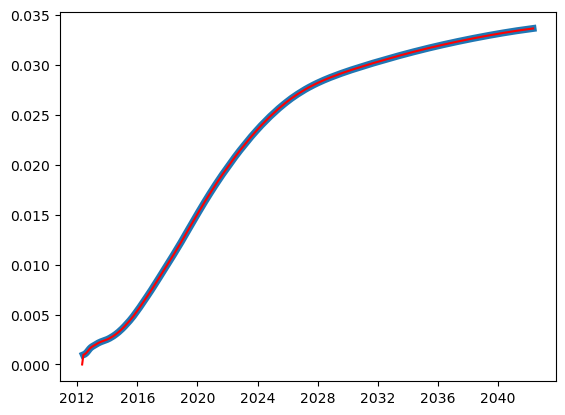

In [320]:
def plot_yc(date, curve: ql.ZeroCurve = None): 
    date_mask = date
    zero_rates = yield_curve.loc[date_mask]
    
    fig, ax = plt.subplots()
    
    dates, rates = zip(*curve.nodes())
    dates = [d.to_date() for d in dates]
    
    print(dates[:3])
    print(rates[:3])
    
    ax.plot(dates[1:], zero_rates, lw='5')
    ax.plot(dates, rates, c='red')
    
plot_yc('2012-04-30', spot_crv)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=809bdc60-6cc4-4659-aae8-7be15b203bd4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>